## POS tagging using modified Viterbi

### Data Preparation

In [548]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [549]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [550]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

### Build the vanilla Viterbi based POS tagger

In [551]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

2739
1175
[[('Packages', 'NOUN'), ('encourage', 'VERB'), ('loyalty', 'NOUN'), ('by', 'ADP'), ('*-1', 'X'), ('rewarding', 'VERB'), ('customers', 'NOUN'), ('for', 'ADP'), ('*', 'X'), ('doing', 'VERB'), ('the', 'DET'), ('bulk', 'NOUN'), ('of', 'ADP'), ('their', 'PRON'), ('banking', 'NOUN'), ('in', 'ADP'), ('one', 'NUM'), ('place', 'NOUN'), ('.', '.')], [('Here', 'ADV'), ('are', 'VERB'), ('*T*-1', 'X'), ('price', 'NOUN'), ('trends', 'NOUN'), ('on', 'ADP'), ('the', 'DET'), ('world', 'NOUN'), ("'s", 'PRT'), ('major', 'ADJ'), ('stock', 'NOUN'), ('markets', 'NOUN'), (',', '.'), ('as', 'ADP'), ('*', 'X'), ('calculated', 'VERB'), ('*-2', 'X'), ('by', 'ADP'), ('Morgan', 'NOUN'), ('Stanley', 'NOUN'), ('Capital', 'NOUN'), ('International', 'NOUN'), ('Perspective', 'NOUN'), (',', '.'), ('Geneva', 'NOUN'), ('.', '.')], [('Pan', 'NOUN'), ('Am', 'VERB'), ('has', 'VERB'), ('subpoenaed', 'VERB'), ('several', 'ADJ'), ('government', 'NOUN'), ('agencies', 'NOUN'), (',', '.'), ('including', 'VERB'), ('the', 

In [552]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70826

In [553]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Packages',
 'encourage',
 'loyalty',
 'by',
 '*-1',
 'rewarding',
 'customers',
 'for',
 '*',
 'doing']

In [554]:
# vocabulary
V = set(tokens)
print(len(V))

10317


In [555]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [556]:
print(T)

{'NUM', 'ADP', 'VERB', 'NOUN', 'PRON', 'CONJ', 'DET', 'X', 'ADV', '.', 'ADJ', 'PRT'}


### Emission Probabilities

In [557]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [558]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [559]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'JJ'))
print(word_given_tag('large', 'VB'))
print(word_given_tag('large', 'NN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NN'))
print(word_given_tag('will', 'VB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NN'))
print(word_given_tag('book', 'VB'))


 large
(0, 0)
(0, 0)
(0, 0) 


 will
(0, 0)
(0, 0)
(0, 0)

 book
(0, 0)
(0, 0)


### Transition Probabilities

In [560]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [561]:
# examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN', 'JJ'))
print(t2_given_t1('NN', 'DT'))
print(t2_given_t1('NNP', 'VB'))
print(t2_given_t1(',', 'NNP'))
print(t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))

(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)


In [562]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DT', '.'))
print(t2_given_t1('VBG', '.'))
print(t2_given_t1('NN', '.'))
print(t2_given_t1('NNP', '.'))

(0, 8215)
(0, 8215)
(0, 8215)
(0, 8215)


In [563]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [564]:
tags_matrix

array([[1.87257186e-01, 3.61305363e-02, 1.74825173e-02, 3.56254846e-01,
        1.16550119e-03, 1.32090133e-02, 3.10800318e-03, 2.01243207e-01,
        3.49650346e-03, 1.17715620e-01, 3.45765352e-02, 2.83605289e-02],
       [6.63411841e-02, 1.68006886e-02, 9.62090772e-03, 3.25244099e-01,
        6.86387122e-02, 1.00516947e-03, 3.21654230e-01, 3.27398032e-02,
        1.47903506e-02, 3.93452048e-02, 1.02240093e-01, 1.57955196e-03],
       [2.32163686e-02, 9.02151987e-02, 1.67285070e-01, 1.11735396e-01,
        3.39234620e-02, 5.72458375e-03, 1.34103686e-01, 2.17216149e-01,
        8.34305063e-02, 3.57256457e-02, 6.56206906e-02, 3.18032429e-02],
       [9.86261014e-03, 1.77526981e-01, 1.45731106e-01, 2.65701681e-01,
        4.26889118e-03, 4.31795865e-02, 1.38370954e-02, 2.97350343e-02,
        1.59960743e-02, 2.38616288e-01, 1.20706577e-02, 4.34739925e-02],
       [6.33245381e-03, 2.11081803e-02, 4.90237474e-01, 2.07915574e-01,
        7.91556761e-03, 5.27704507e-03, 8.44327174e-03, 9.39

In [565]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [566]:
tags_df

,NUM,ADP,VERB,NOUN,PRON,CONJ,DET,X,ADV,.,ADJ,PRT
NUM,0.187257,0.036131,0.017483,0.356255,0.001166,0.013209,0.003108,0.201243,0.003497,0.117716,0.034577,0.028361
ADP,0.066341,0.016801,0.009621,0.325244,0.068639,0.001005,0.321654,0.032740,0.014790,0.039345,0.102240,0.001580
VERB,0.023216,0.090215,0.167285,0.111735,0.033923,0.005725,0.134104,0.217216,0.083431,0.035726,0.065621,0.031803
NOUN,0.009863,0.177527,0.145731,0.265702,0.004269,0.043180,0.013837,0.029735,0.015996,0.238616,0.012071,0.043474
PRON,0.006332,0.021108,0.490237,0.207916,0.007916,0.005277,0.008443,0.093931,0.031662,0.040633,0.073351,0.013193
CONJ,0.042964,0.047945,0.153798,0.354296,0.057908,0.000623,0.120174,0.009963,0.061021,0.033624,0.113325,0.004359
DET,0.022342,0.009622,0.040607,0.632420,0.003098,0.000489,0.005055,0.047293,0.013209,0.018102,0.207436,0.000326
X,0.003456,0.147948,0.203024,0.064147,0.058963,0.010583,0.052700,0.077538,0.024622,0.156803,0.017495,0.182721
ADV,0.029964,0.120751,0.328265,0.034436,0.013417,0.007156,0.072898,0.021467,0.080054,0.138193,0.141324,0.012075
.,0.081558,0.091418,0.089227,0.220816,0.064881,0.058308,0.174680,0.025806,0.053682,0.093731,0.043822,0.001948


In [567]:
tags_df.loc['.', :]

NUM     0.081558
ADP     0.091418
VERB    0.089227
NOUN    0.220816
PRON    0.064881
CONJ    0.058308
DET     0.174680
X       0.025806
ADV     0.053682
.       0.093731
ADJ     0.043822
PRT     0.001948
Name: ., dtype: float32

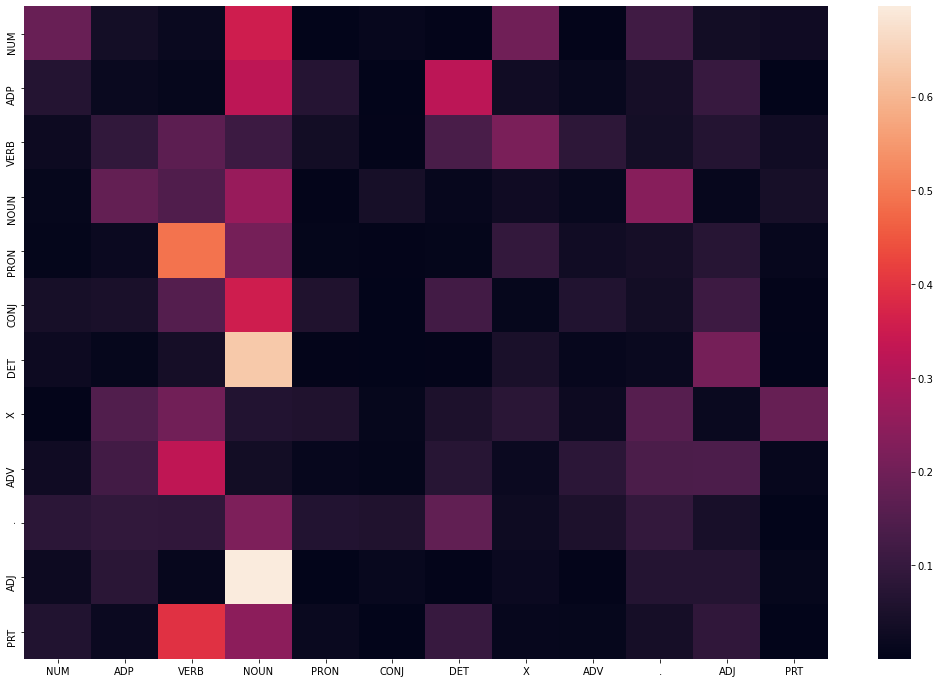

In [568]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

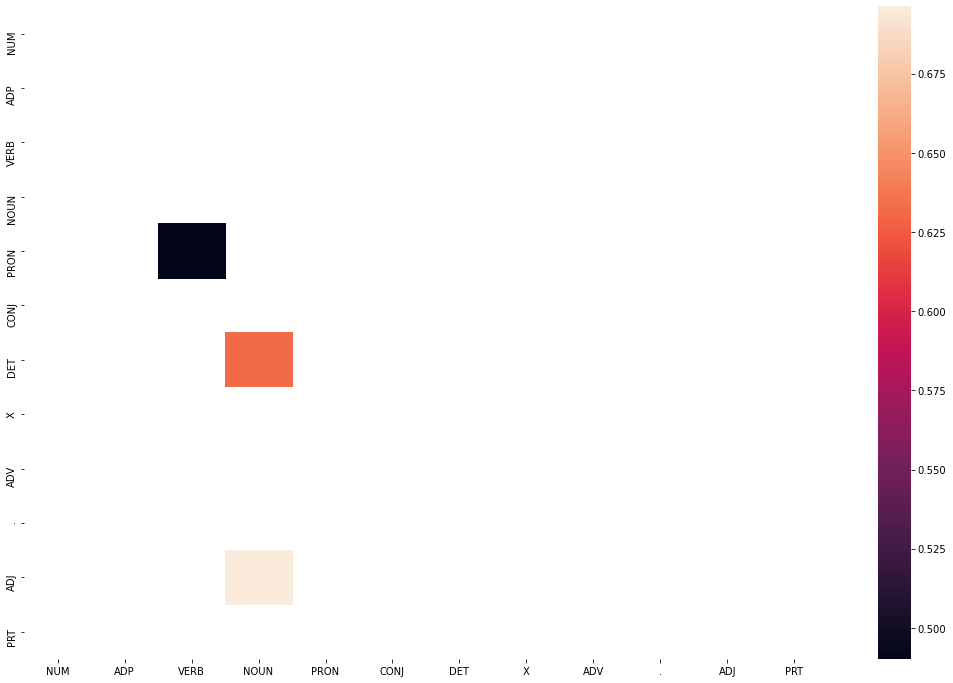

In [569]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.4]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Viterbi Algorithm

In [570]:
len(train_tagged_words)

70826

In [571]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


### Evaluating on Test Set

In [572]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('Nor', 'CONJ'),
  ('are', 'VERB'),
  ('you', 'PRON'),
  ('free', 'ADJ'),
  ('*-2', 'X'),
  ('to', 'PRT'),
  ('reprint', 'VERB'),
  ('such', 'ADJ'),
  ('material', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('I', 'PRON'),
  ('was', 'VERB'),
  ('advised', 'VERB'),
  ('*-31', 'X'),
  ('*T*-1', 'X'),
  ('.', '.')],
 [('Ad', 'NOUN'), ('Notes', 'NOUN'), ('...', '.'), ('.', '.')],
 [('The', 'DET'),
  ('yield', 'NOUN'),
  ('on', 'ADP'),
  ('six-month', 'ADJ'),
  ('Treasury', 'NOUN'),
  ('bills', 'NOUN'),
  ('sold', 'VERB'),
  ('*', 'X'),
  ('at', 'ADP'),
  ('Monday', 'NOUN'),
  ("'s", 'PRT'),
  ('auction', 'NOUN'),
  (',', '.'),
  ('for', 'ADP'),
  ('example', 'NOUN'),
  (',', '.'),
  ('rose', 'VERB'),
  ('to', 'PRT'),
  ('8.04', 'NUM'),
  ('%', 'NOUN'),
  ('from', 'ADP'),
  ('7.90', 'NUM'),
  ('%', 'NOUN'),
  ('.', '.')],
 [('When', 'ADV'),
  ('Scoring', 'NOUN'),
  ('High', 'NOUN'),
  ('first', 'ADV'),
  ('came', 'VERB'),
  ('out', 'ADV'),
  ('in', 'ADP'),
  ('1979', 'NUM'),
  

In [573]:
# tagging the test data
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [574]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  12.839604616165161
[('``', '.'), ('Nor', 'NUM'), ('are', 'VERB'), ('you', 'PRON'), ('free', 'ADJ'), ('*-2', 'X'), ('to', 'PRT'), ('reprint', 'NUM'), ('such', 'ADJ'), ('material', 'NOUN'), (',', '.'), ("''", '.'), ('I', 'PRON'), ('was', 'VERB'), ('advised', 'NUM'), ('*-31', 'X'), ('*T*-1', 'X'), ('.', '.'), ('Ad', 'NUM'), ('Notes', 'NUM'), ('...', '.'), ('.', '.'), ('The', 'DET'), ('yield', 'NOUN'), ('on', 'ADP'), ('six-month', 'ADJ'), ('Treasury', 'NOUN'), ('bills', 'NOUN'), ('sold', 'VERB'), ('*', 'X'), ('at', 'ADP'), ('Monday', 'NOUN'), ("'s", 'PRT'), ('auction', 'NOUN'), (',', '.'), ('for', 'ADP'), ('example', 'NOUN'), (',', '.'), ('rose', 'VERB'), ('to', 'PRT'), ('8.04', 'NUM'), ('%', 'NOUN'), ('from', 'ADP'), ('7.90', 'NUM'), ('%', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('Scoring', 'NOUN'), ('High', 'NOUN'), ('first', 'ADJ'), ('came', 'VERB'), ('out', 'PRT'), ('in', 'ADP'), ('1979', 'NUM'), ('*T*-1', 'X'), (',', '.'), ('it', 'PRON'), ('was', 'VERB'), ('a', '

In [575]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [576]:
accuracy = len(check)/len(tagged_seq)

In [577]:
accuracy

0.8857142857142857

In [578]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [579]:
incorrect_tagged_cases

[[('``', '.'), (('Nor', 'NUM'), ('Nor', 'CONJ'))],
 [('to', 'PRT'), (('reprint', 'NUM'), ('reprint', 'VERB'))],
 [('was', 'VERB'), (('advised', 'NUM'), ('advised', 'VERB'))],
 [('.', '.'), (('Ad', 'NUM'), ('Ad', 'NOUN'))],
 [('Ad', 'NOUN'), (('Notes', 'NUM'), ('Notes', 'NOUN'))],
 [('High', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('came', 'VERB'), (('out', 'PRT'), ('out', 'ADV'))],
 [('a', 'DET'), (('publication', 'NUM'), ('publication', 'NOUN'))]]

In [580]:
## Testing
sentence_test = 'Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter''s firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to AtlantaI would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [581]:
print(tagged_seq)
print(difference)

[('Android', 'NUM'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NUM'), ('.', '.'), ('Android', 'NUM'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'NUM'), ('OS', 'NUM'), ('worldwide', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NUM'), ('and', 'CONJ'), ('Twitter', 'NUM'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NUM'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitters', 'NUM'), ('firehose', 'NUM'), ('.', '.'), ('Twitter', 'NUM'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NUM'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 

### Solve the problem of unknown words

#### Which is the most frequent tag in the corpus

In [582]:
# Which is the most frequent tag in the corpus
# to count the frequency of elements in a list, the Counter() class from collections
# module is very useful, as shown below
tags = [pair[1] for pair in train_tagged_words]

from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NOUN': 20380,
         'VERB': 9433,
         'ADP': 6964,
         'X': 4630,
         'DET': 6132,
         'PRON': 1895,
         'NUM': 2574,
         '.': 8215,
         'ADV': 2236,
         'PRT': 2245,
         'ADJ': 4516,
         'CONJ': 1606})

#### Modification1 : Tags of all unknown words are replaced by Noun (Noun beign the most common tag)

In [583]:
# Viterbi Heuristic - Modifcation1
def Viterbi_modify1(test_words, train_bag = train_tagged_words):
    tagged_seq = Viterbi(test_words)
    V = list(set([pair[0] for pair in train_bag]))
    words = [pair[0] for pair in tagged_seq]
    viterbi_tags = [pair[1] for pair in tagged_seq]
    
    for key, word in enumerate(words):
        if word not in V :
            viterbi_tags[key] = 'NOUN'
                
           
    return list(zip(words, viterbi_tags))

In [584]:
test_Viterbimodify1 = Viterbi_modify1(test_tagged_words)

In [585]:
print(test_Viterbimodify1)

[('``', '.'), ('Nor', 'NOUN'), ('are', 'VERB'), ('you', 'PRON'), ('free', 'ADJ'), ('*-2', 'X'), ('to', 'PRT'), ('reprint', 'NOUN'), ('such', 'ADJ'), ('material', 'NOUN'), (',', '.'), ("''", '.'), ('I', 'PRON'), ('was', 'VERB'), ('advised', 'NOUN'), ('*-31', 'X'), ('*T*-1', 'X'), ('.', '.'), ('Ad', 'NOUN'), ('Notes', 'NOUN'), ('...', '.'), ('.', '.'), ('The', 'DET'), ('yield', 'NOUN'), ('on', 'ADP'), ('six-month', 'ADJ'), ('Treasury', 'NOUN'), ('bills', 'NOUN'), ('sold', 'VERB'), ('*', 'X'), ('at', 'ADP'), ('Monday', 'NOUN'), ("'s", 'PRT'), ('auction', 'NOUN'), (',', '.'), ('for', 'ADP'), ('example', 'NOUN'), (',', '.'), ('rose', 'VERB'), ('to', 'PRT'), ('8.04', 'NUM'), ('%', 'NOUN'), ('from', 'ADP'), ('7.90', 'NUM'), ('%', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('Scoring', 'NOUN'), ('High', 'NOUN'), ('first', 'ADJ'), ('came', 'VERB'), ('out', 'PRT'), ('in', 'ADP'), ('1979', 'NUM'), ('*T*-1', 'X'), (',', '.'), ('it', 'PRON'), ('was', 'VERB'), ('a', 'DET'), ('publication', 'NOUN'), ('of',

In [586]:
# accuracy
check_modf1 = [i for i, j in zip(test_Viterbimodify1, test_run_base) if i == j] 

In [587]:
accuracy_modf1 = len(check_modf1)/len(test_Viterbimodify1)

In [588]:
accuracy_modf1

0.9285714285714286

In [589]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(test_Viterbimodify1, test_run_base)) if j[0]!=j[1]]

In [590]:
incorrect_tagged_cases

[[('``', '.'), (('Nor', 'NOUN'), ('Nor', 'CONJ'))],
 [('to', 'PRT'), (('reprint', 'NOUN'), ('reprint', 'VERB'))],
 [('was', 'VERB'), (('advised', 'NOUN'), ('advised', 'VERB'))],
 [('High', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('came', 'VERB'), (('out', 'PRT'), ('out', 'ADV'))]]

In [591]:
#tagging the test sentence
testSentence_Viterbimodify1 = Viterbi_modify1(words)

In [592]:
testSentence_Viterbimodify1

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitters', 'NOUN'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'N

#### Modification2 : Rule based modifications for unknown words

In [593]:
## Viterbi Modification -2: Rule based
## 1. all unknown words with first letter capital/ all letters capitals are tagged as Noun
## 2. numbers are tagged as NUM
## 3. words ending with '-ous' as ADJ
## 4. and rest as Noun

def Viterbi_modf2(test_words, train_bag = train_tagged_words):
    tagged_seq = Viterbi(test_words)
    V = list(set([pair[0] for pair in train_bag]))
    
    words = [pair[0] for pair in tagged_seq]
    Viterbi_tags = [pair[1] for pair in tagged_seq]
    
    for key, word in enumerate(words):
        if word not in V:
            ## word ending with '-ous', assign a ADJ
            if word[-3:] == 'ous':
                Viterbi_tags[key] = 'ADJ'
            
            ## if word is number i.e. a digit or a set of all digits, except probably the last term like the % symbol 
            # and so on, we assign it as a NUM
            elif (word.isdigit() == True or word.replace('.','',1).isdigit() == True):
                Viterbi_tags[key] = 'NUM'
                
            ## all letters capitalised i.e. words that begin with capital letters or words that are all
            # capital letter are typically proper nouns, so we just assign them as Noun
            elif word.upper() == word:
                Viterbi_tags[key] = 'NOUN'
                
            ## first letter is capitalised:
            elif word[0].upper() == word[0]:
                Viterbi_tags[key] = 'NOUN' 
            
            # and the default is, if we dont know anything, we assign it as Noun
            else: 
                Viterbi_tags[key] = 'NOUN'
    
    return list(zip(words, Viterbi_tags))     

In [594]:
test_Viterbimodf2 = Viterbi_modf2(test_tagged_words)

In [595]:
test_Viterbimodf2

[('``', '.'),
 ('Nor', 'NOUN'),
 ('are', 'VERB'),
 ('you', 'PRON'),
 ('free', 'ADJ'),
 ('*-2', 'X'),
 ('to', 'PRT'),
 ('reprint', 'NOUN'),
 ('such', 'ADJ'),
 ('material', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('I', 'PRON'),
 ('was', 'VERB'),
 ('advised', 'NOUN'),
 ('*-31', 'X'),
 ('*T*-1', 'X'),
 ('.', '.'),
 ('Ad', 'NOUN'),
 ('Notes', 'NOUN'),
 ('...', '.'),
 ('.', '.'),
 ('The', 'DET'),
 ('yield', 'NOUN'),
 ('on', 'ADP'),
 ('six-month', 'ADJ'),
 ('Treasury', 'NOUN'),
 ('bills', 'NOUN'),
 ('sold', 'VERB'),
 ('*', 'X'),
 ('at', 'ADP'),
 ('Monday', 'NOUN'),
 ("'s", 'PRT'),
 ('auction', 'NOUN'),
 (',', '.'),
 ('for', 'ADP'),
 ('example', 'NOUN'),
 (',', '.'),
 ('rose', 'VERB'),
 ('to', 'PRT'),
 ('8.04', 'NUM'),
 ('%', 'NOUN'),
 ('from', 'ADP'),
 ('7.90', 'NUM'),
 ('%', 'NOUN'),
 ('.', '.'),
 ('When', 'ADV'),
 ('Scoring', 'NOUN'),
 ('High', 'NOUN'),
 ('first', 'ADJ'),
 ('came', 'VERB'),
 ('out', 'PRT'),
 ('in', 'ADP'),
 ('1979', 'NUM'),
 ('*T*-1', 'X'),
 (',', '.'),
 ('it', 'PRON'),
 ('was

In [596]:
# accuracy
check_modf2 = [i for i, j in zip(test_Viterbimodf2, test_run_base) if i == j] 
accuracy_modf2 = len(check_modf2)/len(test_Viterbimodf2)

accuracy_modf2

0.9285714285714286

In [597]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(test_Viterbimodf2, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('``', '.'), (('Nor', 'NOUN'), ('Nor', 'CONJ'))],
 [('to', 'PRT'), (('reprint', 'NOUN'), ('reprint', 'VERB'))],
 [('was', 'VERB'), (('advised', 'NOUN'), ('advised', 'VERB'))],
 [('High', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('came', 'VERB'), (('out', 'PRT'), ('out', 'ADV'))]]

In [598]:
#tagging the test sentence
testSentence_Viterbimodify2 = Viterbi_modf2(words)
testSentence_Viterbimodify2

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitters', 'NOUN'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN

#### Modification3 : State probability is dependent only on transition probability for the unknown words

In [599]:
# Viterbi Modification -3: state probability is dependent only on transition probability
def Viterbi_modf3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # MAIN LOGIC
            if word in V:
                state_probability = transition_p * emission_p              
            else:
                state_probability = transition_p
            
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        #print(key)
    return list(zip(words, state))

In [600]:
# tagging the test sentences
test_Viterbimodf3 = Viterbi_modf3(test_tagged_words)

In [601]:
# accuracy
check_modf3 = [i for i, j in zip(test_Viterbimodf3, test_run_base) if i == j] 

accuracy_modf3 = len(check_modf3)/len(test_Viterbimodf3)
print(accuracy_modf3)
# This is not as good, but atleast better than our raw model.

0.9428571428571428


In [602]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(test_Viterbimodf3, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('``', '.'), (('Nor', 'NOUN'), ('Nor', 'CONJ'))],
 [('was', 'VERB'), (('advised', 'X'), ('advised', 'VERB'))],
 [('High', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('came', 'VERB'), (('out', 'PRT'), ('out', 'ADV'))]]

In [603]:
#tagging the test sentence
testSentence_Viterbimodify3 = Viterbi_modf3(words)
testSentence_Viterbimodify3

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitters', 'VERB'),
 ('firehose', 'X'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),

#### Evaluating tagging accuracy

In [604]:
print("Vanilla Viterbi accuracy = ",accuracy)

Vanilla Viterbi accuracy =  0.8857142857142857


In [605]:
print("Accuracy after modification 1 =",accuracy_modf1)

Accuracy after modification 1 = 0.9285714285714286


In [606]:
print("Accuracy after modification 2 =",accuracy_modf2)

Accuracy after modification 2 = 0.9285714285714286


In [607]:
print("Accuracy after modification 3 =",accuracy_modf3)

Accuracy after modification 3 = 0.9428571428571428


#### Accuracy is increased after doing modifications in vanilla Viterbi algorithm

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [608]:
## Increase in accuracy after modification1
print("Accuracy gain after modification 1 :",accuracy_modf1-accuracy)

Accuracy gain after modification 1 : 0.04285714285714293


In [609]:
## Increase in accuracy after modification2
print("Accuracy gain after modification 2 :",accuracy_modf2-accuracy)

Accuracy gain after modification 2 : 0.04285714285714293


In [610]:
## Increase in accuracy after modification3
print("Accuracy gain after modification 3 :",accuracy_modf3-accuracy)

Accuracy gain after modification 3 : 0.05714285714285716


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

1. mood

2. deeds

3. Bramalea

4. 245

 5. Advance